In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/AAA/fluency_adequacy_annotation/

/content/drive/.shortcut-targets-by-id/1CgwA7FpvBMd6M6lLlD9Rv0X2nkT63Etq/AAA/fluency_adequacy_annotation


In [3]:
!pip install krippendorff

In [4]:
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import warnings
import krippendorff
from sklearn.metrics import cohen_kappa_score
import math

## Import the data

In [5]:
# fluency[model][annotator] = {'id' : score, 'id' : score, etc...}

fluency = {}
adequacy = {}
all_annotations = {}

csv_files = glob.glob("./*.csv")
for file in csv_files :
  tmp_df = pd.read_csv(file)
  tmp_df = tmp_df[tmp_df["sarcastic"] == 1]

  file_name = file
  if file_name[-4:] == ".csv" :
    file_name = file_name[:-4]
  file_split = file_name.split("_")
  annotator = file_split[-1]
  model = file_split[-2]
  if model not in fluency :
    fluency[model] = {}
  if model not in adequacy :
    adequacy[model] = {}

  tmp_fluency = tmp_df[~ tmp_df["fluency"].isna()]
  fluency_annotations = tmp_fluency.apply( lambda x : (x["original_ID"], x["fluency"]) , axis= 1 ).tolist()
  if len(fluency_annotations) > 0 :
    fluency[model][annotator] = [x[1] for x in fluency_annotations]
    all_annotations[file + "_fluency"]  = dict(fluency_annotations)

  tmp_adequacy = tmp_df[~ tmp_df["adequacy"].isna()]
  adequacy_annotations = tmp_adequacy.apply( lambda x : (x["original_ID"], x["adequacy"]) , axis= 1 ).tolist()
  if len(adequacy_annotations) > 0 :
    adequacy[model][annotator] = [x[1] for x in adequacy_annotations]
    all_annotations[file + "_adequacy"] = dict(adequacy_annotations)

## Check if everyones annotated the same tweets

In [6]:
for k1, v1 in all_annotations.items() :
  for k2, v2 in all_annotations.items() :
    if k1 != k2 :
      differences = [x for x in v1.keys() if x not in v2.keys()]
      if len(differences) > 0 :
        print(f"The following tweets : {differences} are annotated in {k1} but not {k2}")

## IAA

In [7]:
def rec_krippendorff(** annotations) :
  if len(annotations) > 1 :
    krip_alpha = krippendorff.alpha(reliability_data=list(annotations.values()))
    print(f"Krippendorff's alpha for {list(annotations.keys())} = {krip_alpha}")
    for exclude in annotations :
      rec_krippendorff(**{k : v for k,v in annotations.items() if k != exclude})


In [8]:
def compute_iaa(**annotations) :
  """
  annotations : dict 'annotator' : [.....]
  """
  rec_krippendorff(**annotations)
  for i1, (member1, annot1) in enumerate(annotations.items()) :
    for i2, (member2, annot2) in enumerate(annotations.items()) :
      if i1 < i2 :
        print(f"Cohen's kappa between {member1} and {member2} : {cohen_kappa_score(annot1, annot2)}")

In [21]:
plop = {k : v for k,v in adequacy["substitution"].items()}
compute_iaa(**plop)

Krippendorff's alpha for ['samba', 'ivo', 'zsofia'] = 0.3682647539952184
Krippendorff's alpha for ['ivo', 'zsofia'] = 0.23351461590754574
Krippendorff's alpha for ['samba', 'zsofia'] = 0.6555191317043607
Krippendorff's alpha for ['samba', 'ivo'] = 0.18701732414944672
Cohen's kappa between samba and ivo : 0.2580396192436326
Cohen's kappa between samba and zsofia : 0.5829115205507187
Cohen's kappa between ivo and zsofia : 0.2647939212525904


## Plot

In [ ]:
from ctypes import alignment
def plot_annotations(data, labels=[1,2,3,4,5], agregation='avg', quantiles=[0.25, 0.5, 0.75], quantiles_step=None, minimum_displayed=3, labels_name=None, title="", yticks_side='left') :
  """
  data : either fluency or adequacy
  agregation : avg for mean of every annotators score; or all for everyone; or the name of the annotator otherwise
  """
  plt.figure(figsize=(6.4, 3), dpi=100)

  plt.tick_params(axis='y', labelright=yticks_side == 'right', labelleft=yticks_side == 'left', right=yticks_side == 'right', left=yticks_side == 'left')

  colors = sns.diverging_palette(20, 220, as_cmap=True)( [x / max(labels) for x in labels] )

  if quantiles_step is not None :
    warnings.warn(f"The value of the variable quantiles_step has been set to {quantiles_step} : therefore, the value of quantiles will be ignored")
    quantiles = np.linspace(0, 1, num=quantiles_step)

  agregated = {}
  for k, v in data.items() :
    if agregation == 'avg' :
      agregated[k] = pd.DataFrame(v).mean(axis=1).tolist()
      agregated[k] = [int(x) for x in agregated[k] ]
    elif agregation == 'sum' :
      agregated[k] = []
      for annotator in v :
        agregated[k] += v[annotator]
      nb_annotator = len(v)
    elif agregation == 'all' :
      for annotator in v :
        agregated[k + "_" + annotator] = v[annotator]
    else :
      agregated[k] = v[agregation]

  models = list(agregated.keys())
  counts = {}
  for lb in labels :
    counts[lb] = [ agregated[md].count(lb) for md in models ]
    if agregation == 'sum' :
     counts[lb] = [ round(x / nb_annotator, 2) for x in counts[lb]]

  paddle = 0
  data_cum = [paddle for x in agregated]
  if labels_name is None :
    labels_name = labels

  step = 0.5
  models_nums = [i * step for i,_ in enumerate(models)]
  for i, (label, color, label_name) in enumerate(zip(labels, colors, labels_name)):
        rects = plt.barh(models_nums, counts[label], left=data_cum, height=step / 2,
                        label=label_name, color=color)
        data_cum = [x + y for (x,y) in zip(data_cum, counts[label]) ]
        r, g, b, _ = color
        text_color = 'white' if r * g * b > 0.8 else 'black'
        displayed = [f"{round(x * 100 / sum([counts[lb][j] for lb in labels]))}%" if x >= minimum_displayed else '' for j, x in enumerate(counts[label])]
        plt.bar_label(rects, labels=displayed ,label_type='center', color=text_color) # weight='bold'
  step = 15
  plt.xticks( list(range(0, math.ceil(data_cum[0]) + paddle + step, step)) + [math.ceil(data_cum[0])], fontsize='large')
  plt.xlim(0, math.ceil(data_cum[0]) )
  plt.yticks( models_nums, labels=[x[0].upper() + x[1:] for x in models], fontsize='large')

  plt.legend(bbox_to_anchor=( 0.5, -0.1), loc='upper center', ncol=2, fontsize='large')
  #plt.title(title.split()[2])
  plt.savefig(title+".png", bbox_inches='tight')
  plt.show()

  quantiles_computation = {}
  for md in models :
    quantiles_computation[md] = {}
    for q in quantiles :
      quantiles_computation[md][q] = np.quantile( agregated[md], q, method='closest_observation')
  quantiles_computation = pd.DataFrame(quantiles_computation)
  quantiles_computation.index.name = "quantiles"
  print("\n\nQuantiles")
  display(quantiles_computation)




<ipython-input-10-30697824de42>:14: UserWarning: The value of the variable quantiles_step has been set to 11 : therefore, the value of quantiles will be ignored
  warnings.warn(f"The value of the variable quantiles_step has been set to {quantiles_step} : therefore, the value of quantiles will be ignored")


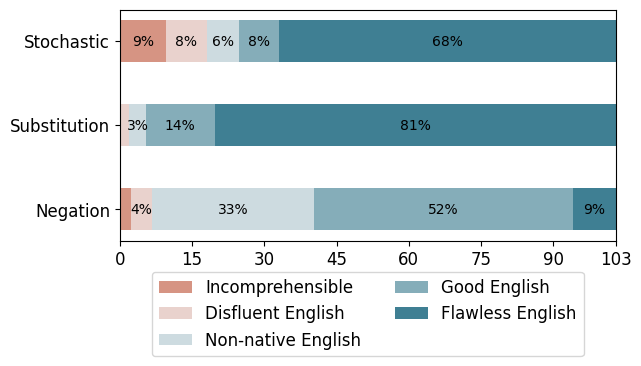



Quantiles


,negation,substitution,stochastic
quantiles,,,
0.0,1.0,1.0,1.0
0.1,3.0,4.0,2.0
0.2,3.0,5.0,3.0
0.3,3.0,5.0,4.0
0.4,4.0,5.0,5.0
0.5,4.0,5.0,5.0
0.6,4.0,5.0,5.0
0.7,4.0,5.0,5.0
0.8,4.0,5.0,5.0


In [ ]:
plot_annotations(fluency, agregation='sum', quantiles_step=11, minimum_displayed=3, title="Counts for Fluency Ratings", labels_name=["Incomprehensible", "Disfluent English", "Non-native English", "Good English", "Flawless English"], yticks_side='left')

<ipython-input-14-199f1f0ee405>:14: UserWarning: The value of the variable quantiles_step has been set to 11 : therefore, the value of quantiles will be ignored
  warnings.warn(f"The value of the variable quantiles_step has been set to {quantiles_step} : therefore, the value of quantiles will be ignored")


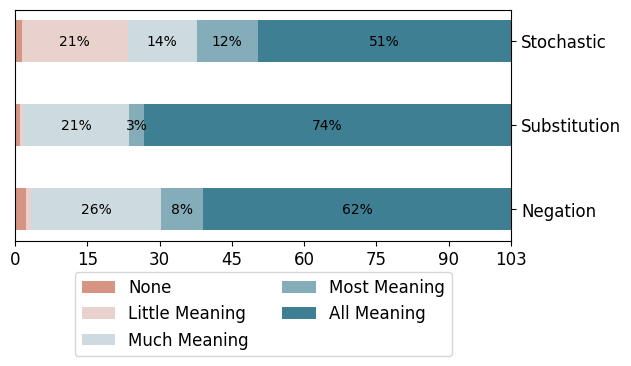



Quantiles


,negation,substitution,stochastic
quantiles,,,
0.0,1.0,1.0,1.0
0.1,3.0,3.0,2.0
0.2,3.0,3.0,2.0
0.3,4.0,5.0,3.0
0.4,5.0,5.0,4.0
0.5,5.0,5.0,5.0
0.6,5.0,5.0,5.0
0.7,5.0,5.0,5.0
0.8,5.0,5.0,5.0


In [ ]:
plot_annotations(adequacy, agregation='sum', quantiles_step=11, minimum_displayed=3, title="Counts for Adequacy Ratings", labels_name=["None", "Little Meaning", "Much Meaning", "Most Meaning", "All Meaning"], yticks_side='right')

## Find which is the best

In [ ]:
def get_best(a) :
  return [int(x == max(a)) for x in a]

def find_best(data, agregation='avg') :
  """
  data : either fluency or adequacy
  agregation : avg for mean of every annotators score; or all for everyone; or the name of the annotator otherwise
  """

  agregated = {}
  for k, v in data.items() :
    if agregation == 'avg' :
      agregated[k] = pd.DataFrame(v).mean(axis=1).tolist()
      agregated[k] = [int(x) for x in agregated[k] ]
    else :
      agregated[k] = v[agregation]

  agregated = pd.DataFrame(agregated)

  display(agregated)

  is_best_tmp = agregated.apply(lambda x : get_best(x.tolist()) , axis=1)
  is_best = {}
  for i, col in enumerate(agregated.columns) :
    is_best[col] = [ x[i] for x in is_best_tmp.tolist() ]
  is_best = pd.DataFrame(is_best)
  is_best.loc["mean"] = is_best.mean()

  display(is_best)

In [ ]:
find_best(fluency)

,negation,substitution,stochastic
0,4,5,5
1,4,4,5
2,4,4,4
3,3,3,5
4,3,5,5
...,...,...,...
98,3,4,3
99,3,5,5
100,5,5,3
101,3,4,4


,negation,substitution,stochastic
0,0.00000,1.000000,1.00000
1,0.00000,0.000000,1.00000
2,1.00000,1.000000,1.00000
3,0.00000,0.000000,1.00000
4,0.00000,1.000000,1.00000
...,...,...,...
99,0.00000,1.000000,1.00000
100,1.00000,1.000000,0.00000
101,0.00000,1.000000,1.00000
102,0.00000,0.000000,1.00000
